# Module 4

## Video 20: Cargo Movements Example
**Python for the Energy Industry**

In this lesson, we'll consider another example of querying the SDK, having a look at Cargo Movements. To start with, we will search for all cargos that are currently being loaded. We specify the start and end times using a `datetime` object - this will be discussed in more detail in the next module.

Documentation for the Cargo Movements endpoint can be [found here.](https://vortechsa.github.io/python-sdk/endpoints/cargo_movements/)

In [ ]:
import vortexasdk as v
from datetime import datetime
now = datetime.utcnow()

In [1]:
cm_query = v.CargoMovements().search(
    filter_activity="loading_state",
    filter_time_min=now,
    filter_time_max=now)

2020-12-10 15:12:17,839 vortexasdk.client — WARNING — You are using vortexasdk version 0.26.0, however version 0.27.1 is available.
You should consider upgrading via the 'pip install vortexasdk --upgrade' command.


Loading from API: 1000it [00:01, 680.07it/s]             


In [2]:
# How many cargo movements do we get?
len(cm_query)

780

In [3]:
# What does a single cargo movement look like?
cm_query[0]

{'cargo_movement_id': '002fb0cdde927e8758bfdc001d016388002fb0cdde927e8758bfdc001d016388',
 'quantity': 26102,
 'status': 'unloaded_state',
 'vessels': [{'id': 'bd959e52a27d98d327ccdcdbc543ee325aafd6eaa9a1752e1d0e9f4e7b353bd8',
   'mmsi': 319498000,
   'imo': 9102095,
   'name': 'STOLT CREATIVITY',
   'dwt': 37271,
   'cubic_capacity': 39808,
   'vessel_class': 'handysize',
   'corporate_entities': [{'id': 'afd995e6928b97fa3799141cec71ed674f739528dd14af15be3791b02f287699',
     'label': 'Stolt Tankers',
     'layer': 'commercial_owner',
     'probability': 1,
     'source': 'external'}],
   'start_timestamp': '2020-10-30T23:42:06+0000',
   'end_timestamp': '2020-11-08T01:47:40+0000',
   'fixture_fulfilled': False,
   'voyage_id': '9e307b22b8ab351b2a471d168b1ccbda3cc6fe8f6bc41173b8f2794e24efdda3',
   'tags': [{'tag': 'vessel_coated_tag'}],
   'status': 'vessel_status_laden_known',
   'year': 1997,
   'scrubber': [],
   'flag': [{'tag': 'vessel_flag_tag',
     'flag': 'KY',
     'flag_cou

Let's choose what bit of information we would like to put in a DataFrame. We'll go with:
- Load and unload port locations
- Product group label
- Vessel name and type
- Coordinates

Notice how some of this information is 'nested', i.e. the value associated with a key might itself be a dictionary or a list. See below how we specify the column names to access this information.

In [4]:
cm_df = cm_query.to_df(columns=['events.cargo_port_load_event.0.location.port.label',
                               'events.cargo_port_unload_event.0.location.port.label',
                               'product.group.label',
                               'quantity',
                               'vessels.0.name',
                               'vessels.0.vessel_class',
                               'events.cargo_port_load_event.0.pos.0',
                               'events.cargo_port_load_event.0.pos.1'])

These column names are quite long and will make our DataFrame harder to read, so we can use a dictionary to relabel them.

In [5]:
relabel = {'events.cargo_port_load_event.0.location.port.label':'load_port',
           'events.cargo_port_unload_event.0.location.port.label':'unload_port',
           'product.group.label':'product_group',
           'vessels.0.name':'vessel_name',
           'vessels.0.vessel_class':'vessel_class',
           'events.cargo_port_load_event.0.pos.0':'load_X',
           'events.cargo_port_load_event.0.pos.1':'load_Y'}

cm_df = cm_df.rename(relabel,axis=1)

In [6]:
# Let's take a peek at the data
cm_df.head(3)

,load_port,unload_port,product_group,quantity,vessel_name,vessel_class,load_X,load_Y
0,Bintulu (Tanjong Kidurong) [MY],Kaohsiung [TW],Clean Petroleum Products,26102,STOLT CREATIVITY,handysize,113.075177,3.259798
1,Mesaieed [QA],Singapore [SG],Clean Petroleum Products,64621,MARITIME ROSEMARY,handymax,51.577603,24.930121
2,Dalian [CN],"Jiangyin, Fuzhou [CN]",Clean Petroleum Products,523896,QI LIN ZUO,panamax,121.280508,39.578469


Now that we've got our data in a DataFrame, we can visualise it with plots. Histograms are convenient for working with numerical data:

array([[<AxesSubplot:title={'center':'quantity'}>]], dtype=object)

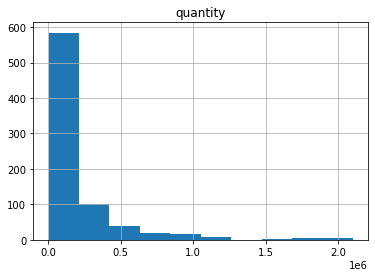

In [7]:
# Histogram of quantity
cm_df.hist(column='quantity')

There are a couple of ways we can try to make this data easier to visualise. Firstly, we note that the number of bins is relatively small, so we can increase it:

array([[<AxesSubplot:title={'center':'quantity'}>]], dtype=object)

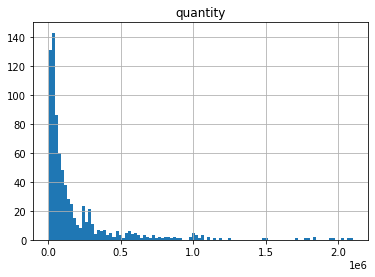

In [8]:
cm_df.hist(column='quantity',bins=100)

This doesn't help much, as the data is still very skewed. Another thing we can try is to plot the logarithm of quantity instead of quantity:

array([[<AxesSubplot:title={'center':'log quantity'}>]], dtype=object)

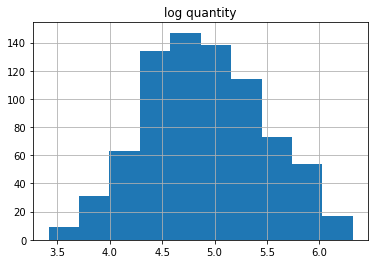

In [9]:
import numpy as np
cm_df['log quantity'] = np.log10(cm_df['quantity'])
cm_df.hist(column='log quantity')

This is a fair bit easier to interpret - we can see that quantity broadly varies from 10k bbl to 1M bbl, with a mode around 100k bbl. We can see from this plot that the distribution of quantity appears to be approximately log-normal.

Let's try a different example - what if we were interested in the composition of vessel classes in these cargo movements?

In [10]:
# Start by grouping by vessel class and counting
cm_df_classes = cm_df.groupby('vessel_class').count()
cm_df_classes

,load_port,unload_port,product_group,quantity,vessel_name,load_X,load_Y,log quantity
vessel_class,,,,,,,,
aframax,48,44,48,48,48,48,48,48
general_purpose,160,157,161,161,161,161,161,161
handymax,150,141,151,151,151,151,151,151
handysize,101,95,102,102,102,101,101,102
lgc,5,5,5,5,5,5,5,5
mgc,4,4,6,6,6,6,6,6
panamax,27,26,27,27,27,27,27,27
sgc,47,50,50,50,50,50,50,50
suezmax,29,27,29,29,29,29,29,29


Because we are using `.count()`, columns have the same values except where data is missing. We want to pick one column with no data missing (say, vessel_name) to use for a pie chart.

We also note that the number of vessels in classes lgc and mgc are very small, so we shall ignore these.

<AxesSubplot:>

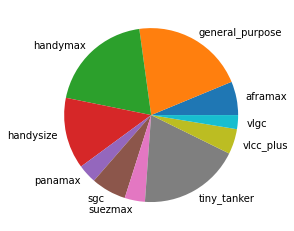

In [11]:
# Drop vessel classes with fewer than 10 vessels (so just lgc and mgc)
cm_df_classes = cm_df_classes[cm_df_classes['vessel_name'] >= 10]

# Plot pie chart
cm_df_classes.plot.pie(y='vessel_name', legend=False, ylabel='')

### Exercise

Make a scatter plot of the X and Y coordinates. Does this look how you would expect?